In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [10]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [11]:
# установим необходимые библиотеки

# для находления координат
!pip install geopy
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="smy-application")

# для OneHotEncorder
!pip install category_encoders
import category_encoders as ce

# для обработки отзывов
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

# для регулярных выражений
import re

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/asya/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [13]:
# Подгрузим наши данные из соревнования

DATA_DIR = 'data/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [15]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [16]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [17]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [18]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [19]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [20]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [22]:
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
reviewer_score                                    38
dtype: int64

## Создание, удаление и корректировка признаков

### Работаем с признаком hotel_address

In [23]:
# получаем из адреса город и страну, в которой находится отель

def get_city_country(info):
    info = info.strip()
    info_list = info.split()
    info_list = info_list[-2:]

    if info_list[0]=='United' and info_list[1]=='Kingdom':
        info_list[0]='London'
        info_list[1]='United Kingdom'

    return info_list[0] + ', ' + info_list[1]

data['location'] = data['hotel_address'].apply(get_city_country)

In [24]:
# посмотрим, сколько всего уникальных значений и сохраним их в список

location_list = list(data['location'].unique())
location_list

['Milan, Italy',
 'Amsterdam, Netherlands',
 'Barcelona, Spain',
 'London, United Kingdom',
 'Paris, France',
 'Vienna, Austria']

In [25]:
# удалим признак

data.drop('hotel_address', axis=1, inplace=True)

In [26]:
# закодируем признак location методом OneHoeEncoding

encoder = ce.OneHotEncoder(cols='location')
type_bin = encoder.fit_transform(data['location'])
data = pd.concat([data, type_bin], axis=1)

### Заполним пробелы в признаках lat, lng, используя данные из нового признака 'location'

In [27]:
# получим координаты для всех 6-ти локаций

coord_for_basic_location = dict()

for city in location_list:
    coord_city = dict()
    location = geolocator.geocode(city)
    coord_city['lat'] = location.latitude
    coord_city['lng'] = location.longitude
    coord_for_basic_location[city] = coord_city

print(coord_for_basic_location)


{'Milan, Italy': {'lat': 45.4641943, 'lng': 9.1896346}, 'Amsterdam, Netherlands': {'lat': 52.3727598, 'lng': 4.8936041}, 'Barcelona, Spain': {'lat': 41.3828939, 'lng': 2.1774322}, 'London, United Kingdom': {'lat': 51.5073219, 'lng': -0.1276474}, 'Paris, France': {'lat': 48.8588897, 'lng': 2.3200410217200766}, 'Vienna, Austria': {'lat': 48.2083537, 'lng': 16.3725042}}


In [28]:
# заполним пропущенные координаты

def get_geolocation(*x):
    lat, lng, location, coord = x
    
    if np.isnan(lat) or np.isnan(lng):
        lat = coord[location]['lat']
        lng = coord[location]['lng']

    return lat, lng


data[['lat','lng']] = data[['lat','lng','location']].apply(lambda x: pd.Series(get_geolocation(*x, coord_for_basic_location)), axis=1)

In [29]:
# удалим признак

data.drop('location', axis=1, inplace=True)

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   review_date                                 515738 non-null  object 
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

### Работа с признаком review_date

In [31]:
# преобразуем в дату
data['review_date'] = pd.to_datetime(data['review_date'])

#заберем из даты месяц
data['month'] = pd.DatetimeIndex(data['review_date']).month

In [32]:
# удалим признак

data.drop('review_date', axis=1, inplace=True)

### Работа с признаком tags

In [33]:
# получаем всё множество тегов и выведем их количество

def get_set_tags(tags):
    tag_set = set()

    for hotel_tags in tags:

        hotel_tags = hotel_tags.lstrip("['")
        hotel_tags = hotel_tags.rstrip("']")
        hotel_tags_list = hotel_tags.split("', '")

        for tag in hotel_tags_list:
            tag = tag.strip()
            tag_set.add(tag)

    return tag_set


tag_set = get_set_tags(data['tags'])
print(len(tag_set))

2428


In [34]:
%%time
#считаем количесво каждого тега во всех отзывах и сохраняем всё в датафрейм, сортируем по убыванию количества

def get_count_tags(tags, data_tags):
    dict_tags = {}

    for tag in tags:
        cnt = 0

        for tags_str in data_tags:
            if tag in tags_str:
                cnt+=1
        
        dict_tags[tag]=cnt

    tags_data=pd.DataFrame({"tag": dict_tags.keys(), "count": dict_tags.values()})
    tags_data.sort_values(by='count', ascending=False, inplace=True, ignore_index=True)
    
    return tags_data

tags_data = get_count_tags(tag_set,data['tags'])

CPU times: user 7min 17s, sys: 740 ms, total: 7min 18s
Wall time: 7min 22s


In [35]:
# выберем самые популярные теги и создадим на их основе новые признаки
popular_tag_list = list(tags_data[tags_data['count']>10000]['tag'])

for tag in popular_tag_list:
    tag_in_text = "' "+tag+" '"
    data['tag_'+tag] = data['tags'].apply(lambda x: 1 if tag_in_text in x else 0)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 57 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   reviewer_nationality                        515738 non-null  object 
 4   negative_review                             515738 non-null  object 
 5   review_total_negative_word_counts           515738 non-null  int64  
 6   total_number_of_reviews                     515738 non-null  int64  
 7   positive_review                             515738 non-null  object 
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

In [36]:
# удалим признак
data.drop('tags', axis=1, inplace=True)

### Работа с отзывами

In [37]:
# добавим новый признак для оценки значений положительных и отрицательных отзывов

def get_review_value(*x):
    neg_review, pos_review = x

    values = sent_analyzer.polarity_scores(neg_review)
    neg_value = values['neg']

    values = sent_analyzer.polarity_scores(pos_review)
    pos_value = values['pos']

    return neg_value, pos_value

In [38]:
data[['negative_value', 'positive_value']] = data[['negative_review','positive_review']].apply(lambda x: pd.Series(get_review_value(*x)), axis=1)

In [39]:
# заменим текст отзывов на 0 или 1, если есть негативные или позитивные
data['negative_review'] = data['negative_review'].apply(lambda x: 0 if x=='No Negative' else 1)
data['positive_review'] = data['positive_review'].apply(lambda x: 0 if x=='No Positive' else 1)

### Работа с признаком days_since_review

In [40]:
# получим численное значение того, сколько дней прошло
def get_days_count(string):
    
    days_count = re.findall("\d+", string)
    return int(days_count[0])

In [41]:
data['days_since_review'] = data['days_since_review'].apply(get_days_count)

### Работа с признаком reviewer_nationality

In [42]:
# Посмотрим на соотношение национальностей гостей отелей
print(data['reviewer_nationality'].value_counts(normalize=True))

 United Kingdom               0.475524
 United States of America     0.068711
 Australia                    0.042048
 Ireland                      0.028749
 United Arab Emirates         0.019845
                                ...   
 Comoros                      0.000002
 Anguilla                     0.000002
 Tuvalu                       0.000002
 Cape Verde                   0.000002
 Palau                        0.000002
Name: reviewer_nationality, Length: 227, dtype: float64


В основном (около ~50%) рецензентов из Великобритании. Создадим новый признак, Который будет равен 1, если рецендент из Великобритании. В остальных случаях = 0

In [43]:
data['reviewer_from_UK'] = data['reviewer_nationality'].apply(lambda x: 1 if x.strip()=='United Kingdom' else 0)

In [44]:
# удалим признак
data.drop('reviewer_nationality', axis=1, inplace=True)

### Работа с признаком hotel_name

In [45]:
# т.к. название отеля не должно влиять на оценку, удалим этот признак
data.drop('hotel_name', axis=1, inplace=True)

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 57 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   negative_review                             515738 non-null  int64  
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   positive_review                             515738 non-null  int64  
 6   review_total_positive_word_counts           515738 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 8   days_since_review                           515738 non-null  int64  
 9   lat                                         515738 non-null  float64
 

## Отбор признаков

In [47]:
# т.к. признаков очень много, вместо тепловой карты напишем ф-ию, которая выведет те признаки, где корреляция > 0.7
#мультиколлинеарность
def get_mylticoll(data, val=0.7):
    correl = data.corr()

    index_list = list(correl.index)
    column_list = list(correl.columns)
    multicoll_list = []

    for index in index_list:

        for column in column_list:

            correl_index = round(correl.loc[index,column],2)
            if ((correl_index <-1*val) or (correl_index > val)) and index!=column:

                if multicoll_list.count([column,index])==0:
                    multicoll_list.append([index,column])

    return multicoll_list


print(get_mylticoll(data.drop(['sample'], axis=1)))

[['additional_number_of_scoring', 'total_number_of_reviews'], ['negative_review', 'negative_value'], ['lat', 'location_3'], ['lng', 'location_6'], ['tag_Leisure trip', 'tag_Business trip']]


In [48]:
# addition_number_of_scoring, tag_Business_trip, negative_value
data.drop(['additional_number_of_scoring','tag_Business trip','negative_value','location_3','location_6'], axis=1, inplace=True)

<AxesSubplot:>

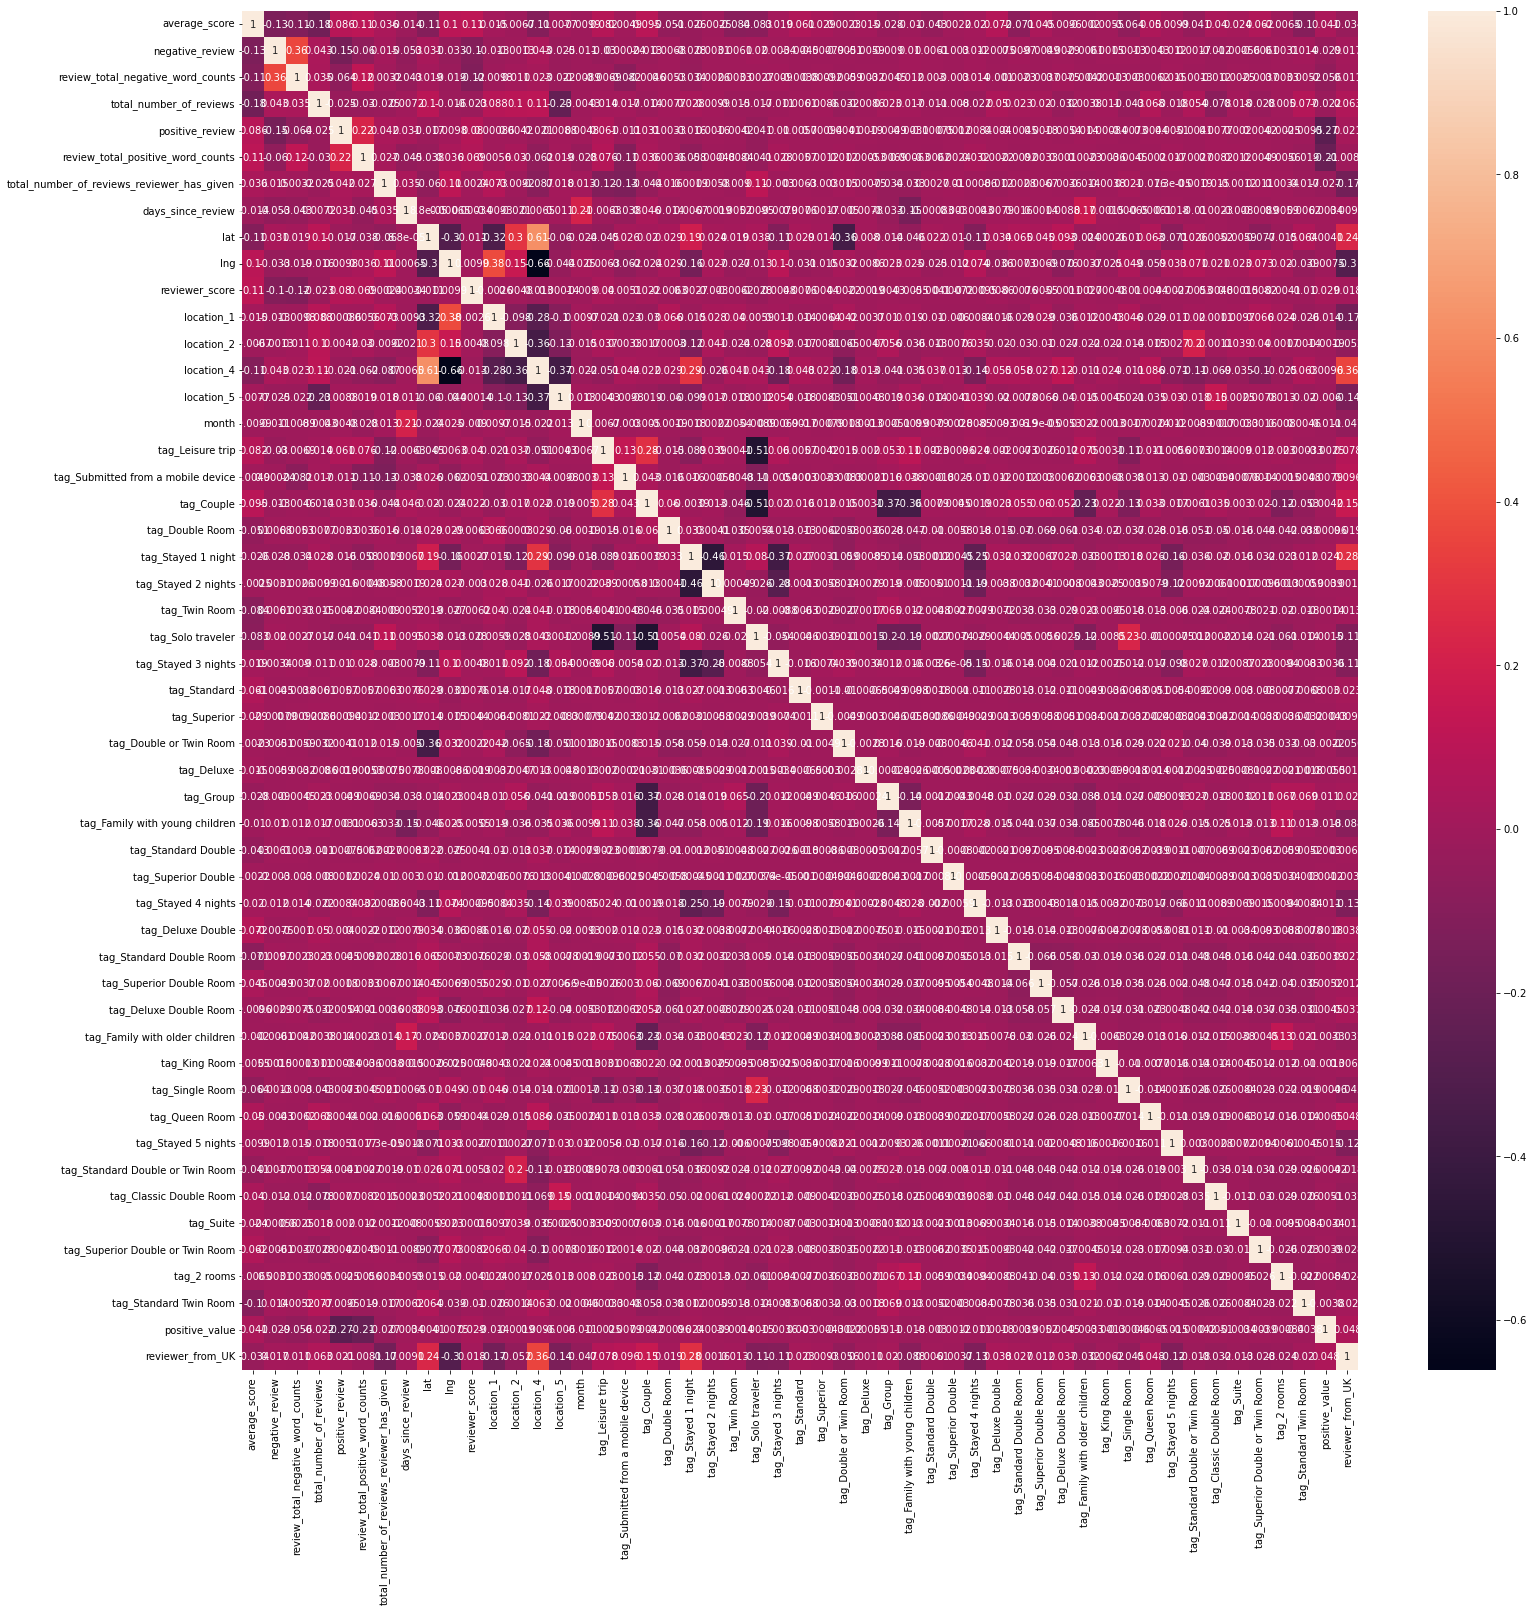

In [49]:
plt.rcParams['figure.figsize'] = (25,25)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 52 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   negative_review                             515738 non-null  int64  
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   positive_review                             515738 non-null  int64  
 5   review_total_positive_word_counts           515738 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 7   days_since_review                           515738 non-null  int64  
 8   lat                                         515738 non-null  float64
 9   lng                                         515738 non-null  float64
 

In [51]:
# укажем категориальные признаки
category_colums = ['negative_review',
       'positive_review',
       'lat', 'location_1', 'location_2',
       'location_4', 'location_5', 'month', 'tag_Leisure trip',
       'tag_Submitted from a mobile device', 'tag_Couple', 'tag_Double Room',
       'tag_Stayed 1 night', 'tag_Stayed 2 nights', 'tag_Twin Room',
       'tag_Solo traveler', 'tag_Stayed 3 nights', 'tag_Standard',
       'tag_Superior', 'tag_Double or Twin Room', 'tag_Deluxe', 'tag_Group',
       'tag_Family with young children', 'tag_Standard Double',
       'tag_Superior Double', 'tag_Stayed 4 nights', 'tag_Deluxe Double',
       'tag_Standard Double Room', 'tag_Superior Double Room',
       'tag_Deluxe Double Room', 'tag_Family with older children',
       'tag_King Room', 'tag_Single Room', 'tag_Queen Room',
       'tag_Stayed 5 nights', 'tag_Standard Double or Twin Room',
       'tag_Classic Double Room', 'tag_Suite',
       'tag_Superior Double or Twin Room', 'tag_2 rooms',
       'tag_Standard Twin Room', 'reviewer_from_UK']

In [52]:
# укажем числовые признаки
numeric_colums = ['average_score',
       'review_total_negative_word_counts',
       'total_number_of_reviews', 'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'positive_value']

In [53]:
# выберем в качестве Х данные для обучения и выберем категориальные признаки
X = data[data['sample']==1].drop(['reviewer_score'], axis = 1)  

# выберем в качестве у целевой признак
y = data[data['sample']==1]['reviewer_score'] 
y=y.astype('int')

<AxesSubplot:>

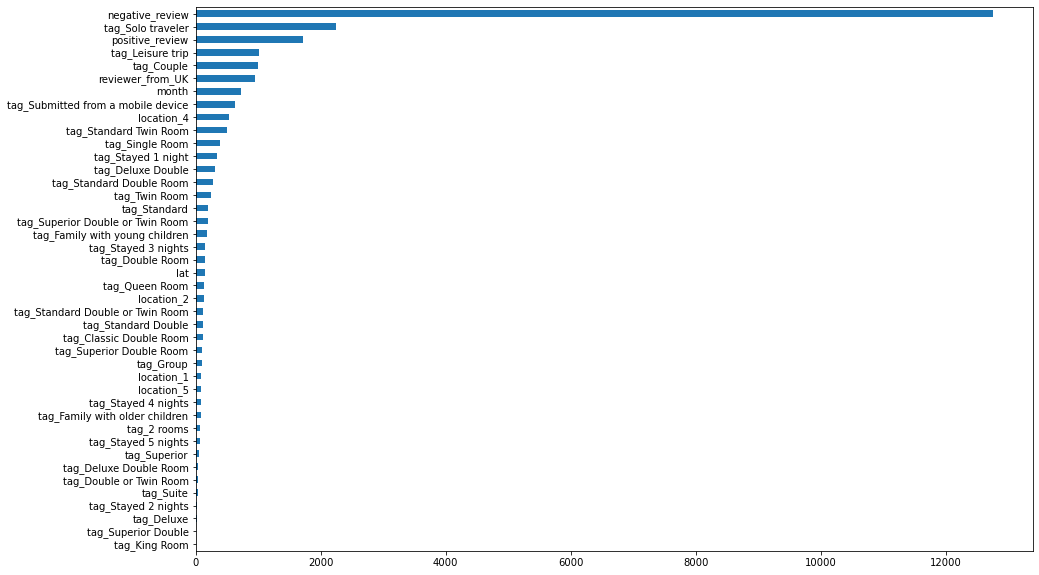

In [54]:
# проверка значимости категориальных признаков методом хи квадрат

from sklearn.feature_selection import chi2 
plt.rcParams['figure.figsize'] = (15,10)
important_cat = pd.Series(chi2(X[category_colums], y)[0], index=category_colums)
important_cat.sort_values(inplace = True)
important_cat.plot(kind = 'barh')

In [55]:
# Оставим следующие категориальные признаки (рейтинг более 150)
result_columns = ['reviewer_score', 'sample']
result_columns.extend(important_cat[important_cat >= 150].index)

In [56]:
result_columns

['reviewer_score',
 'sample',
 'tag_Double Room',
 'tag_Stayed 3 nights',
 'tag_Family with young children',
 'tag_Superior Double or Twin Room',
 'tag_Standard',
 'tag_Twin Room',
 'tag_Standard Double Room',
 'tag_Deluxe Double',
 'tag_Stayed 1 night',
 'tag_Single Room',
 'tag_Standard Twin Room',
 'location_4',
 'tag_Submitted from a mobile device',
 'month',
 'reviewer_from_UK',
 'tag_Couple',
 'tag_Leisure trip',
 'positive_review',
 'tag_Solo traveler',
 'negative_review']

<AxesSubplot:>

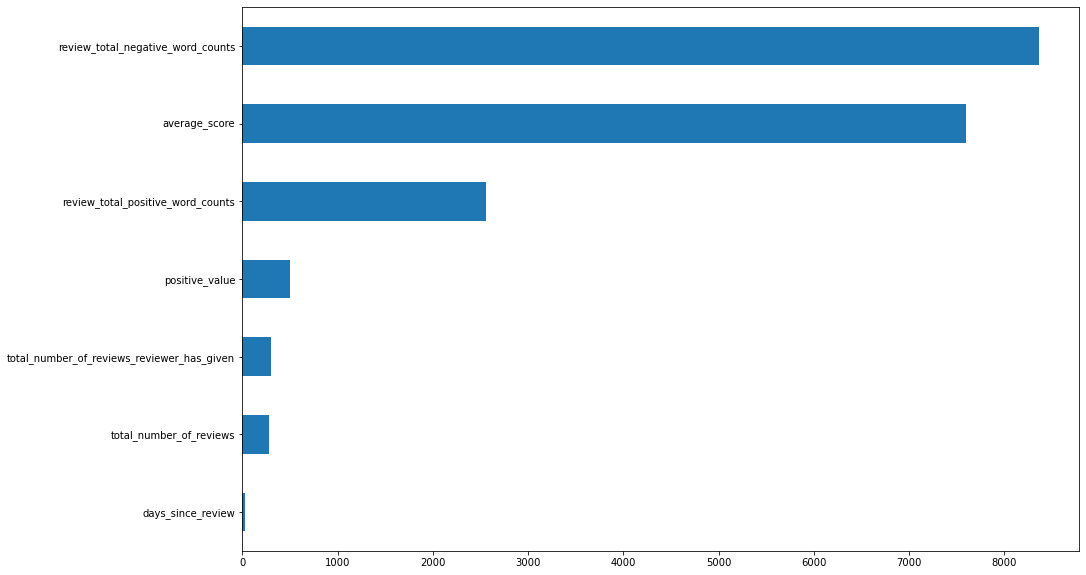

In [57]:
# проверка значимости числовых признаков тестом anova

from sklearn.feature_selection import f_classif # anova

plt.rcParams['figure.figsize'] = (15,10)
important_num = pd.Series(f_classif(X[numeric_colums], y)[0], index = numeric_colums)
important_num.sort_values(inplace = True)
important_num.plot(kind = 'barh')

In [58]:
# Оставим следующие числовые признаки (рейтинг более 100)
result_columns.extend(important_num[important_num >= 100].index)
result_columns

['reviewer_score',
 'sample',
 'tag_Double Room',
 'tag_Stayed 3 nights',
 'tag_Family with young children',
 'tag_Superior Double or Twin Room',
 'tag_Standard',
 'tag_Twin Room',
 'tag_Standard Double Room',
 'tag_Deluxe Double',
 'tag_Stayed 1 night',
 'tag_Single Room',
 'tag_Standard Twin Room',
 'location_4',
 'tag_Submitted from a mobile device',
 'month',
 'reviewer_from_UK',
 'tag_Couple',
 'tag_Leisure trip',
 'positive_review',
 'tag_Solo traveler',
 'negative_review',
 'total_number_of_reviews',
 'total_number_of_reviews_reviewer_has_given',
 'positive_value',
 'review_total_positive_word_counts',
 'average_score',
 'review_total_negative_word_counts']

In [59]:
# соберем все данные
data = data[result_columns]

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   reviewer_score                              515738 non-null  float64
 1   sample                                      515738 non-null  int64  
 2   tag_Double Room                             515738 non-null  int64  
 3   tag_Stayed 3 nights                         515738 non-null  int64  
 4   tag_Family with young children              515738 non-null  int64  
 5   tag_Superior Double or Twin Room            515738 non-null  int64  
 6   tag_Standard                                515738 non-null  int64  
 7   tag_Twin Room                               515738 non-null  int64  
 8   tag_Standard Double Room                    515738 non-null  int64  
 9   tag_Deluxe Double                           515738 non-null  int64  
 

## Создание модели

In [61]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [62]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [63]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 27), (386803, 27), (386803, 26), (309442, 26), (77361, 26))

In [64]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [65]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [66]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.2s finished


In [67]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAPE: 13.17302578717986


<AxesSubplot:>

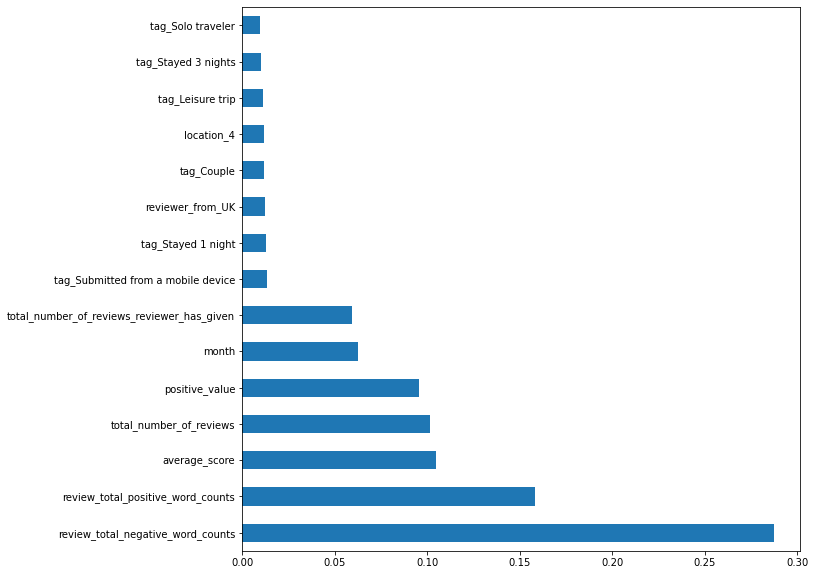

In [68]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [69]:
test_data.sample(10)

,reviewer_score,tag_Double Room,tag_Stayed 3 nights,tag_Family with young children,tag_Superior Double or Twin Room,tag_Standard,tag_Twin Room,tag_Standard Double Room,tag_Deluxe Double,tag_Stayed 1 night,...,tag_Leisure trip,positive_review,tag_Solo traveler,negative_review,total_number_of_reviews,total_number_of_reviews_reviewer_has_given,positive_value,review_total_positive_word_counts,average_score,review_total_negative_word_counts
17446,0.0,0,0,0,0,1,0,0,0,0,...,1,1,0,1,3611,3,0.580,21,9.1,14
776,0.0,1,0,0,0,0,0,0,0,1,...,1,1,0,1,823,28,0.306,10,8.1,24
12065,0.0,0,1,0,0,0,0,0,0,0,...,1,1,1,1,1407,1,0.804,3,8.1,13
61169,0.0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,2122,93,0.330,15,7.6,0
35964,0.0,0,0,0,0,0,0,0,0,1,...,1,1,0,1,1505,3,0.000,3,8.2,12
79616,0.0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,2058,4,0.320,10,8.8,0
113811,0.0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1842,60,0.608,12,8.2,60
128654,0.0,0,0,0,0,0,0,0,0,1,...,1,1,0,1,3826,3,0.335,31,8.1,12
75496,0.0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,597,45,0.000,4,7.4,0
20800,0.0,0,0,0,0,0,0,1,0,0,...,1,1,0,1,3117,3,0.000,5,7.8,20


In [70]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [71]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [72]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    6.2s finished


In [73]:
predict_submission

array([8.789     , 6.747     , 8.862     , ..., 7.997     , 9.632     ,
       7.52033333])

In [74]:
list(sample_submission)

['reviewer_score', 'id']

In [75]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('data/submission5.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.789,488440
1,6.747,274649
2,8.862,374688
3,9.783,404352
4,9.210,451596
5,8.542,302161
6,7.818,317079
7,7.476,13963
8,8.304,159785
9,7.521,195089
